# Microsoft Professional Program for Data Science 
# Final Exam

## Goal of this project:

The goal of this project is to analyze the rate spread of mortgage applications according to the given dataset, which is adapted from the Federal Financial Institutions Examination Council's (FFIEC).

This Jupyter notebook shall give first insights into the data, clean it and prepare it for further processing.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as nr
import math
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import os

%matplotlib inline
pd.set_option('display.max_columns', None)

In [30]:
DATA_PATH = os.path.realpath(os.getcwd()+"/../data/")  # Data source directory
TEMP_PATH = os.path.realpath(os.getcwd()+"/../temp/")  # Temporary directory

TRAIN_DATA_FN = 'train_values.csv'  # Train data CSV
TRAIN_LABELS_FN = "train_labels.csv"  # Label data CSV
CLEANED_OUTPUT_FN = "train_cleaned.csv"  # Cleaned training data
CLEANED_OUTPUT_FN_XLS = "train_cleaned.xlsx"  # Cleaned training data
TEST_VALUES_FN = "test_values.csv"  # Test value CS

## Load the training data and merge it with the label data

In [3]:
training_data_pd = pd.read_csv(DATA_PATH+TRAIN_DATA_FN)
training_labels_pd = pd.read_csv(DATA_PATH+TRAIN_LABELS_FN)

training_data_pd = pd.merge(training_data_pd, training_labels_pd, on='row_id', how='left')

training_data_pd.head(5)

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,rate_spread
0,0,2,1,1,1,139.0,1,261,14,246,2,5,1,77.0,5949.0,11.642,63192.0,100.000,1556.0,1993.0,2094,True,1.0
1,1,2,2,1,1,160.0,3,349,48,311,1,5,1,42.0,2667.0,37.141,63693.0,75.729,875.0,1163.0,4194,False,2.0
2,2,1,2,1,1,168.0,3,385,30,256,3,2,1,34.0,6393.0,79.635,42883.0,76.948,636.0,1611.0,1119,False,3.0
3,3,1,2,1,1,57.0,3,117,30,46,1,6,1,37.0,7175.0,72.843,63806.0,78.836,1587.0,2172.0,1119,False,6.0
4,4,2,1,2,1,25.0,3,95,41,192,2,5,2,46.0,5041.0,23.188,70908.0,59.579,756.0,1992.0,1593,False,4.0


## Investigating the training data

### Loan information

* msa_md - Number, Metropolitan Statistical Area/Metropolitan Division, -1 = unknown
* state_code - Number, U.S. state, -1 = unknown
* county_code - Number, County, -1 = unknown
* loan_amount = The amount of money request in dollars
* loan_type - defines whether the loan granted/applied/purchased was conventional, government-guaranteed, or government-insured
    * 1 -- Conventional (any loan other than FHA, VA, FSA, or RHS loans)
    * 2 -- FHA-insured (Federal Housing Administration)
    * 3 -- VA-guaranteed (Veterans Administration)
    * 4 -- FSA/RHS (Farm Service Agency or Rural Housing Service)
* property_type - Defines for which amount of families the house was intended
    * 1 -- One to four-family (other than manufactured housing)
    * 2 -- Manufactured housing
    * 3 -- Multifamily
* loan_purpose - Defines for which goal the loan was requested
    * 1 -- Home purchase
    * 2 -- Home improvement
    * 3 -- Refinancing
* occupancy - Defines if the loan is intended for the owner's dwelling or otherwise
    * 1 -- Owner-occupied as a principal dwelling
    * 2 -- Not owner-occupied
    * 3 -- Not applicable
* preapproval - Indicate whether the application or loan involved a request for a pre-approval    
    * 1 -- Owner-occupied as a principal dwelling
    * 2 -- Not owner-occupied
    * 3 -- Not applicable

### Applicant information

* applicant_income - The applicant's income in thousands of dollars
* applicant_ethnicity - Defines the applicant's ethnicity
    * 1 -- Hispanic or Latino
    * 2 -- Not Hispanic or Latino
    * 3 -- Information not provided by applicant in mail, Internet, or telephone pplication
    * 4 -- Not applicable
    * 5 -- No co-applicant
* applicant_race - The applicant's ethnicity
    * 1 -- American Indian or Alaska Native
    * 2 -- Asian
    * 3 -- Black or African American
    * 4 -- Native Hawaiian or Other Pacific Islander
    * 5 -- White
    * 6 -- Information not provided by applicant in mail, Internet, or telephone application
    * 7 -- Not applicable
    * 8 -- No co-applicant
* applicant_sex - The applicant's sex
    * 1 -- Male
    * 2 -- Female
    * 3 -- Information not provided by applicant in mail, Internet, or telephone application
    * 4 or 5 -- Not applicable
* co_applicant - Defines if there is a co-applicant (like the applicant's spouse)

### Census information (about the neighbourhood)

* population - Total population in tract
* minority_population_pct - Percentage of minority population to total population for tract
* ffiecmedian_family_income - FFIEC Median family income in dollars for the MSA/MD in which the tract is located (adjusted annually by FFIEC)
* tract_to_msa_md_income_pct - % of tract median family income compared to MSA/MD median family income
* number_of_owner-occupied_units - Number of dwellings, including individual condominiums, that are lived in by the owner
* number_of_1_to_4_family_units - Dwellings that are built to house fewer than 5 families


In [4]:
training_data_pd.head(10)

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,rate_spread
0,0,2,1,1,1,139.0,1,261,14,246,2,5,1,77.0,5949.0,11.642,63192.0,100.000,1556.0,1993.0,2094,True,1.0
1,1,2,2,1,1,160.0,3,349,48,311,1,5,1,42.0,2667.0,37.141,63693.0,75.729,875.0,1163.0,4194,False,2.0
2,2,1,2,1,1,168.0,3,385,30,256,3,2,1,34.0,6393.0,79.635,42883.0,76.948,636.0,1611.0,1119,False,3.0
3,3,1,2,1,1,57.0,3,117,30,46,1,6,1,37.0,7175.0,72.843,63806.0,78.836,1587.0,2172.0,1119,False,6.0
4,4,2,1,2,1,25.0,3,95,41,192,2,5,2,46.0,5041.0,23.188,70908.0,59.579,756.0,1992.0,1593,False,4.0
5,5,2,1,1,1,88.0,2,261,50,92,2,5,2,53.0,3278.0,4.913,55945.0,100.000,1141.0,2647.0,2800,True,1.0
6,6,2,1,1,1,345.0,3,80,9,232,1,5,1,90.0,3827.0,16.331,114291.0,67.921,1113.0,1352.0,3797,True,1.0
7,7,2,1,1,1,123.0,3,189,3,207,1,5,1,38.0,5975.0,47.466,73584.0,52.528,1033.0,1766.0,2428,False,1.0
8,8,1,2,1,1,68.0,3,128,33,150,1,6,1,35.0,7294.0,24.169,57170.0,90.570,2078.0,2790.0,1268,True,2.0
9,9,1,2,1,1,27.0,3,261,29,119,2,5,1,39.0,6331.0,4.057,47600.0,96.910,1515.0,2436.0,1268,True,8.0


In [5]:
training_data_pd.describe()

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,rate_spread
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,189292.000000,198005.000000,198005.000000,198015.000000,197977.000000,197988.000000,197984.000000,200000.000000,200000.000000
mean,99999.500000,1.570935,1.154880,1.482605,1.061385,142.574940,2.702950,226.974970,28.202045,166.335230,1.915310,4.762685,1.417540,73.617902,5391.099099,34.238640,64595.355801,89.283022,1402.872401,1927.336618,2001.311505,1.979110
std,57735.171256,0.559410,0.365066,0.822156,0.246043,142.559487,0.545658,106.655259,15.593383,92.852518,0.513273,0.887328,0.577133,105.696934,2669.028807,27.930882,12724.514485,15.059223,706.880410,886.576586,1271.134197,1.656809
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,7.000000,0.326000,17860.000000,6.193000,3.000000,6.000000,0.000000,1.000000
25%,49999.750000,1.000000,1.000000,1.000000,1.000000,67.000000,2.000000,154.000000,14.000000,83.000000,2.000000,5.000000,1.000000,39.000000,3717.000000,10.928000,56654.000000,81.648000,932.000000,1344.000000,963.000000,1.000000
50%,99999.500000,2.000000,1.000000,1.000000,1.000000,116.000000,3.000000,261.000000,30.000000,181.000000,2.000000,5.000000,1.000000,56.000000,4959.000000,25.996000,63485.000000,98.959000,1304.000000,1799.000000,1834.000000,1.000000
75%,149999.250000,2.000000,1.000000,2.000000,1.000000,179.000000,3.000000,318.000000,41.000000,249.000000,2.000000,5.000000,2.000000,83.000000,6470.000000,52.000000,71238.000000,100.000000,1742.000000,2353.000000,3180.000000,2.000000
max,199999.000000,4.000000,3.000000,3.000000,3.000000,11104.000000,3.000000,408.000000,52.000000,316.000000,4.000000,7.000000,4.000000,10042.000000,34126.000000,100.000000,125095.000000,100.000000,8747.000000,13615.000000,4283.000000,99.000000


## Investigating the target labels

* row_id - The row identifier, must match the source row id
* rate_spread - The difference between a typical mortage and the mortage defined for this applicant

In [6]:
training_labels_pd.head(10)

,row_id,rate_spread
0,0,1.0
1,1,2.0
2,2,3.0
3,3,6.0
4,4,4.0
5,5,1.0
6,6,1.0
7,7,1.0
8,8,2.0
9,9,8.0


In [7]:
training_labels_pd.describe()

,row_id,rate_spread
count,200000.000000,200000.000000
mean,99999.500000,1.979110
std,57735.171256,1.656809
min,0.000000,1.000000
25%,49999.750000,1.000000
50%,99999.500000,1.000000
75%,149999.250000,2.000000
max,199999.000000,99.000000


In [8]:
spread_col = training_labels_pd['rate_spread']
print("Spread rate: Min {}, Max {}, Mean {}, Median {}".format(spread_col.min(), spread_col.max(), spread_col.mean(), spread_col.median()))

Spread rate: Min 1.0, Max 99.0, Mean 1.97911, Median 1.0


### Initial discovery goals:

* Minimum loan rate spread
* Maximum loan rate spread
* Mean loan rate spread
* Median loan rate spread
* Standard deviation of loan rate spread
* Visualize the loan rate spread as histogram
* Which two of the following statements are true?
    * Applicants where applicant_ethnicity=3 have a higher rate spread on average than where applicant_ethnicity=1.
    * Applicants where applicant_ethnicity=3 have a lower rate spread on average than where applicant_ethnicity=1.
    * Applicants where applicant_sex=1 have a lower rate spread on average than where applicant_sex=2.
    * Applicants where applicant_sex=1 have a higher rate spread on average than where applicant_sex=2.
* For applicants in state 43, which of the following best describes the relationship between applicant income and loan amount?
    * A — A higher applicant income is associated with a higher loan amount, on average.
    * B — A higher applicant income is associated with a lower loan amount, on average.
    * C — There is not a strong and obvious correlation between applicant income and loan amount, on average.
* Limiting just to state 48 and ignoring where county is missing (missing value being -1), which of the following statements is true?
    * A — In state 48, the average rate spread across counties varies substantially, ranging from 0% to 10%.
    * B — In state 48, the average rate spread across counties varies substantially, ranging from around 1% to around 7%.
    * C — Counties within state 48 all have similar levels of loan rates.    
* Loan types across states -Looking just at states 2 and 3 and just loan types 1, 2, and 3 which of the following statements is true?
    * A — For loan types  1 ,  2 , and  3 , the average rate spread in state  2  is higher than the overall rate among states  2  and  3 .
    * B — For loan types  1 ,  2 , and  3 , the average rate spread in state  3  is lower than the overall rate among states  2  and  3 
    * C — For loan types  1 ,  2 , and  3 , the average rate spread in state  2  is higher than for the corresponding loan type in state  3 .
    * D — For loan types  1 ,  2 , and  3 , the average rate spread in state  2  is lower than for the corresponding loan type in state  3 .
* Data ethics: With great power comes great responsibility. Part of the responsibilities of a data scientist includes thinking about the ethical implications of your work, such as was discussed during the MPP course. It is therefore important to be able to spot when different ethical issues may arise.

    For the following scenario, familiarize yourself with, then use this Data Science Ethics Checklist, (part of the open source deon command line tool) to find the most relevant ethical concerns.
A bank wants to improve its creditworthiness assessment and decides to hire a team of data scientists to build an algorithm to predict the likelihood that an applicant will default on their loan. The data science team finds that whether or not a loan applicant graduated from a highly selective college is a good predictor of loan default. If this feature is used in the bank's algorithm, which ethical concern is most salient? https://github.com/drivendataorg/deon/blob/master/examples/ethics.md

    * D1: Proxy discrimination
    * C3: Honest representation
    * E4: Unintended use
    * B1: Data security

* For the following scenario, familiarize yourself with, then use this Data Science Ethics Checklist, (part of the open source deon command line tool) to choose the best answer.

    The data science team decides to bring in social media data as they have found that the creditworthiness of an applicant's friends is a good indicator of the applicant's own creditworthiness. Which set of ethical concerns is most relevant here?
    
    * C5: Auditability, E3: Concept drift
    * E4: Unintended use, D3: Metric selection
    * C2: Dataset bias, D2: Fairness across groups    

## Outlier removal

There are some very obvious outliers which we will remove at this point so they won't negatively influence the further processing.. It are just a dozen values (within the dataset of 20,000) values whose values are extremely off at mortage rates near 100.

In [9]:
from scipy import stats
training_data_pd = training_data_pd[(np.abs(stats.zscore(training_data_pd[['rate_spread']])) < 4).all(axis=1)]
print(training_data_pd.count())

row_id                            199783
loan_type                         199783
property_type                     199783
loan_purpose                      199783
occupancy                         199783
loan_amount                       199783
preapproval                       199783
msa_md                            199783
state_code                        199783
county_code                       199783
applicant_ethnicity               199783
applicant_race                    199783
applicant_sex                     199783
applicant_income                  189112
population                        197801
minority_population_pct           197801
ffiecmedian_family_income         197811
tract_to_msa_md_income_pct        197773
number_of_owner-occupied_units    197784
number_of_1_to_4_family_units     197780
lender                            199783
co_applicant                      199783
rate_spread                       199783
dtype: int64


## Rate spread distribution

In the chart below you can see the distribution of the rate spread. It his heavily right skewed. The huge majority of the applicatants seems to be located within the 1 to 3% region. Above this region the minority of the applicant's is located which a though still not insignifant amount.

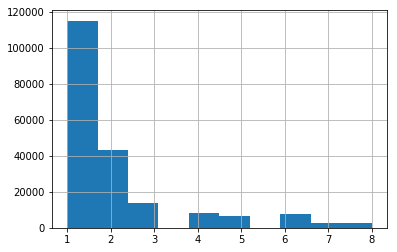

In [10]:
training_data_pd['rate_spread'].hist(bins=10)

In [11]:
bequal_1 = training_data_pd[training_data_pd['rate_spread']<=1].shape[0]/training_data_pd.shape[0]
print("{:.2f}% of credits below or equal to a spread of 1%".format(bequal_1*100))
bequal_2 = training_data_pd[training_data_pd['rate_spread']<=2].shape[0]/training_data_pd.shape[0]
print("{:.2f}% of credits below or equal to a spread of 2%".format(bequal_2*100))
bequal_3 = training_data_pd[training_data_pd['rate_spread']<=3].shape[0]/training_data_pd.shape[0]
print("{:.2f}% of credits below or equal to a spread of 3%".format(bequal_3*100))
bequal_4 = training_data_pd[training_data_pd['rate_spread']<=4].shape[0]/training_data_pd.shape[0]
print("{:.2f}% of credits below or equal to a spread of 4%".format(bequal_4*100))
bequal_5 = training_data_pd[training_data_pd['rate_spread']<=5].shape[0]/training_data_pd.shape[0]
print("{:.2f}% of credits below or equal to a spread of 5%".format(bequal_5*100))
bequal_10 = training_data_pd[training_data_pd['rate_spread']<=8].shape[0]/training_data_pd.shape[0]
print("{:.2f}% of credits below or equal to a spread of 10%".format(bequal_10*100))

dist_df = pd.DataFrame()
dist_df['<= 1%'] = [bequal_1*100]
dist_df['<= 2%'] = [bequal_2*100]
dist_df['<= 3%'] = [bequal_3*100]
dist_df['<= 4%'] = [bequal_4*100]
dist_df['<= 5%'] = [bequal_5*100]
dist_df['<= 10%'] = [bequal_10*100]

57.61% of credits below or equal to a spread of 1%
79.36% of credits below or equal to a spread of 2%
86.20% of credits below or equal to a spread of 3%
90.35% of credits below or equal to a spread of 4%
93.53% of credits below or equal to a spread of 5%
100.00% of credits below or equal to a spread of 10%


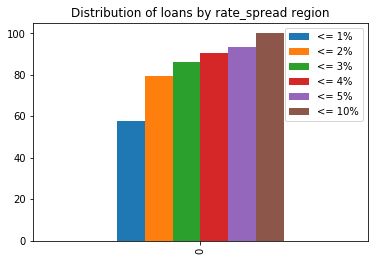

In [12]:
dist_df.plot(kind='bar')
plt.title("Distribution of loans by rate_spread region")
plt.show()

In [13]:
# 

In [14]:
sex_dict = {1 : 'Male (1)', 2: 'Female (2)', 3: 'Unknown', 4: 'Unknown', 5: 'Unknown'}
race_dict = {1 : 'Native(1)', 2: 'Asian(2)', 3: 'Black/African(3)', 4: 'Hawaiian/Pacific(4)', 5: 'White(5)', 6: 'Unknown', 7: 'Unknown', 8: 'Unknown'}
eth_dict = {1: 'Hispanic/Latino(1)', 2: 'Non-Hispanic(2)', 3: 'Unknown(3)', 4: 'Unknown(4)', 5: 'Unknown(5)'}
loan_type_dict = {1: 'Conventional(1)', 2: 'FHA-insured(2)', 3: 'VA-guaranteed(3)', 4: 'FSA/RHS(4)'}
property_type_dict = {1: '1-4-family-non-mf(1)', 2: 'Manufactured housing(2)', 3: 'Multifamily(3)'}
purpose_dict = {1: 'Home purchase(1)', 2: 'Home improvement(2)', 3: 'Refinancing(3)'}

training_data_pd['sex'] = training_data_pd['applicant_sex'].map(sex_dict)
training_data_pd['ethnicity'] = training_data_pd['applicant_ethnicity'].map(eth_dict)
training_data_pd['race'] = training_data_pd['applicant_race'].map(race_dict)
training_data_pd['loan_type_name'] = training_data_pd['loan_type'].map(loan_type_dict)
training_data_pd['property_type_name'] = training_data_pd['property_type'].map(property_type_dict)
training_data_pd['purpose_name'] = training_data_pd['loan_purpose'].map(purpose_dict)

training_data_pd.head(5)

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,rate_spread,sex,ethnicity,race,loan_type_name,property_type_name,purpose_name
0,0,2,1,1,1,139.0,1,261,14,246,2,5,1,77.0,5949.0,11.642,63192.0,100.000,1556.0,1993.0,2094,True,1.0,Male (1),Non-Hispanic(2),White(5),FHA-insured(2),1-4-family-non-mf(1),Home purchase(1)
1,1,2,2,1,1,160.0,3,349,48,311,1,5,1,42.0,2667.0,37.141,63693.0,75.729,875.0,1163.0,4194,False,2.0,Male (1),Hispanic/Latino(1),White(5),FHA-insured(2),Manufactured housing(2),Home purchase(1)
2,2,1,2,1,1,168.0,3,385,30,256,3,2,1,34.0,6393.0,79.635,42883.0,76.948,636.0,1611.0,1119,False,3.0,Male (1),Unknown(3),Asian(2),Conventional(1),Manufactured housing(2),Home purchase(1)
3,3,1,2,1,1,57.0,3,117,30,46,1,6,1,37.0,7175.0,72.843,63806.0,78.836,1587.0,2172.0,1119,False,6.0,Male (1),Hispanic/Latino(1),Unknown,Conventional(1),Manufactured housing(2),Home purchase(1)
4,4,2,1,2,1,25.0,3,95,41,192,2,5,2,46.0,5041.0,23.188,70908.0,59.579,756.0,1992.0,1593,False,4.0,Female (2),Non-Hispanic(2),White(5),FHA-insured(2),1-4-family-non-mf(1),Home improvement(2)


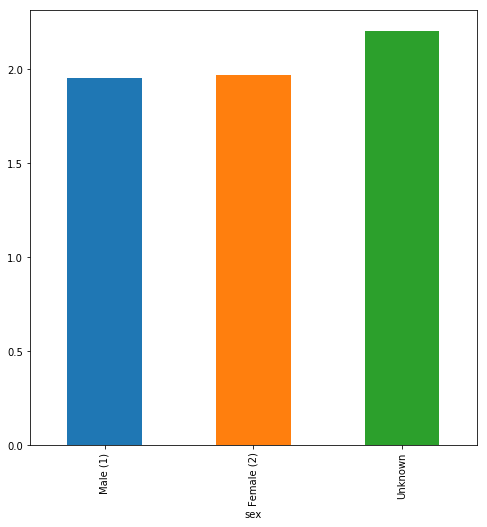

In [15]:
f = plt.figure(figsize=(8, 8))
training_data_pd.groupby('sex')['rate_spread'].mean().sort_values().plot(kind='bar')

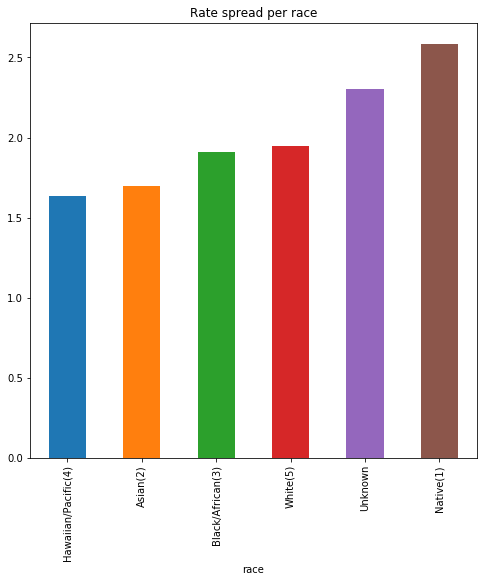

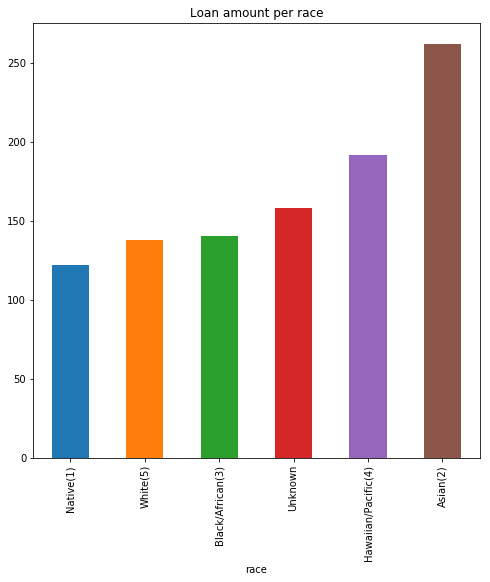

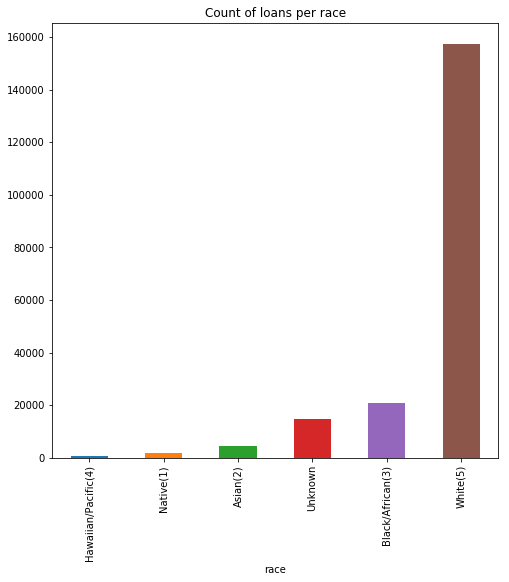

In [16]:
f = plt.figure(figsize=(8, 8))
training_data_pd.groupby('race')['rate_spread'].mean().sort_values().plot(kind='bar')
plt.title("Rate spread per race")
plt.show()
f = plt.figure(figsize=(8, 8))
training_data_pd.groupby('race')['loan_amount'].mean().sort_values().plot(kind='bar')
plt.title("Loan amount per race")
plt.show()
f = plt.figure(figsize=(8, 8))
training_data_pd.groupby('race')['loan_amount'].count().sort_values().plot(kind='bar')
plt.title("Count of loans per race")
plt.show()

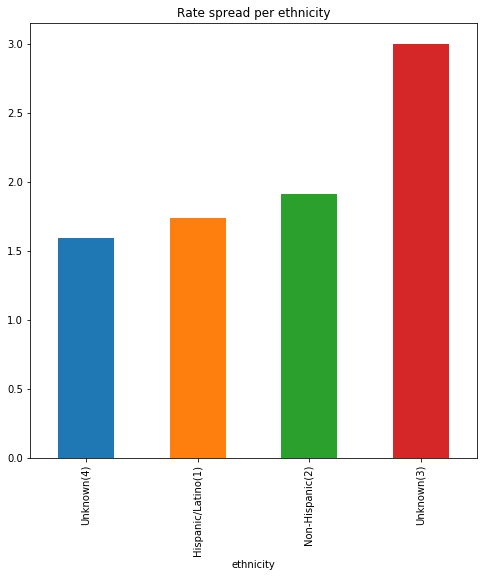

In [17]:
f = plt.figure(figsize=(8, 8))
training_data_pd.groupby('ethnicity')['rate_spread'].mean().sort_values().plot(kind='bar')
plt.title("Rate spread per ethnicity")
plt.show()

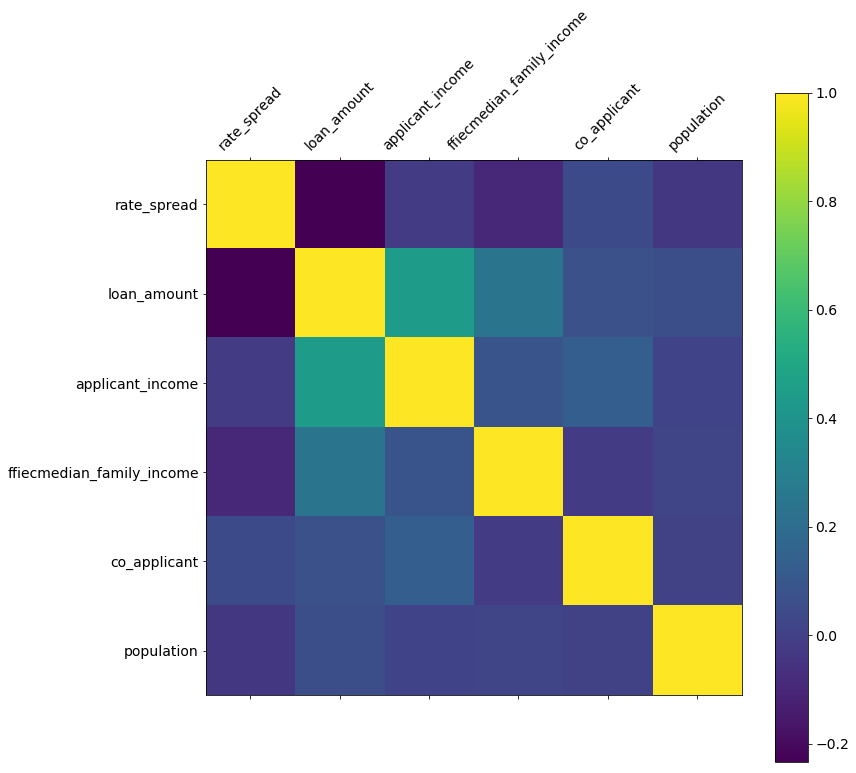

In [18]:
# training_data_pd[['applicant_income', 'loan_amount']].plot(kind='scatter')

df = training_data_pd[['rate_spread', 'loan_amount', 'applicant_income', 'ffiecmedian_family_income', 'co_applicant', 'population']]
f = plt.figure(figsize=(12, 12))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

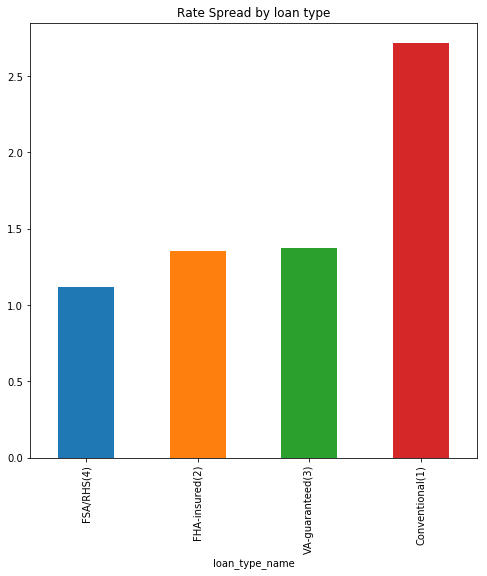

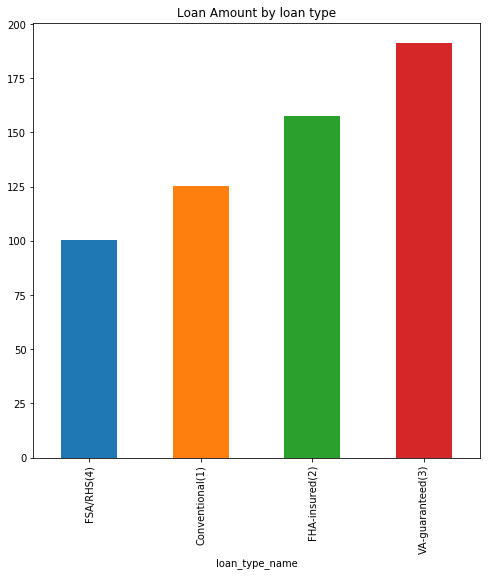

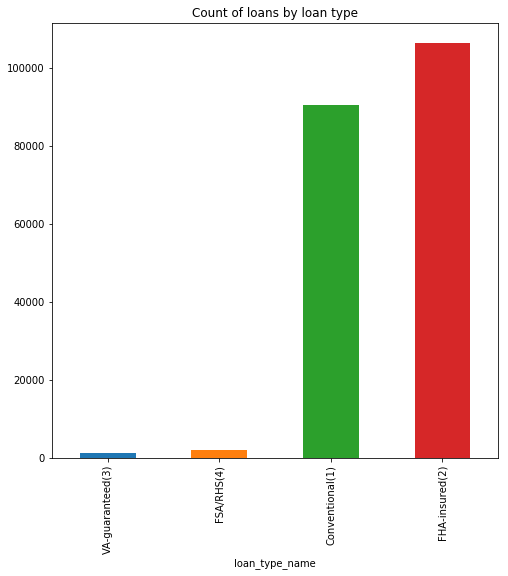

In [19]:
f = plt.figure(figsize=(8, 8))
training_data_pd.groupby('loan_type_name')['rate_spread'].mean().sort_values().plot(kind='bar')
plt.title('Rate Spread by loan type')
plt.show()
f = plt.figure(figsize=(8, 8))
training_data_pd.groupby('loan_type_name')['loan_amount'].mean().sort_values().plot(kind='bar')
plt.title('Loan Amount by loan type')
plt.show()
f = plt.figure(figsize=(8, 8))
plt.title('Count of loans by loan type')
training_data_pd.groupby('loan_type_name')['rate_spread'].count().sort_values().plot(kind='bar')
plt.show()

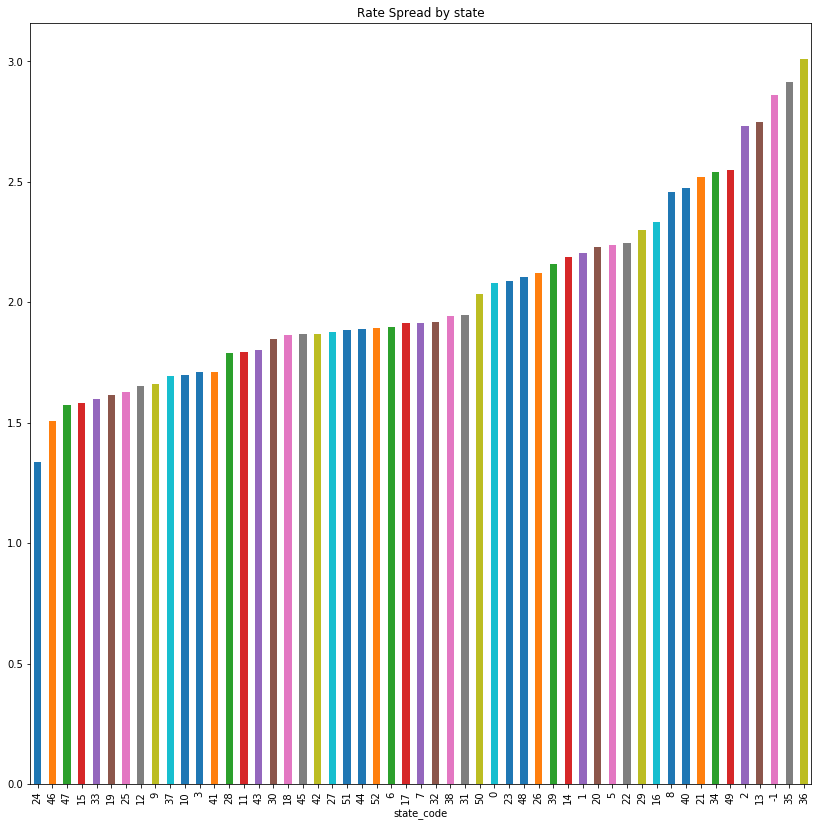

In [20]:
f = plt.figure(figsize=(14, 14))
training_data_pd.groupby('state_code')['rate_spread'].mean().sort_values().plot(kind='bar')
plt.title('Rate Spread by state')
plt.show()

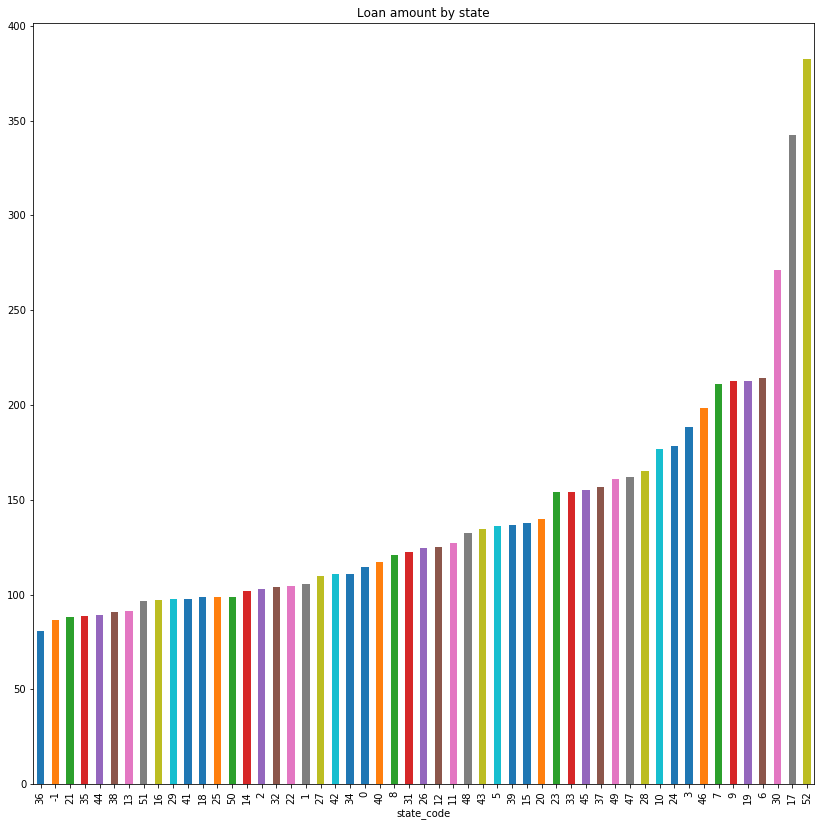

In [21]:
f = plt.figure(figsize=(14, 14))
training_data_pd.groupby('state_code')['loan_amount'].mean().sort_values().plot(kind='bar')
plt.title('Loan amount by state')
plt.show()

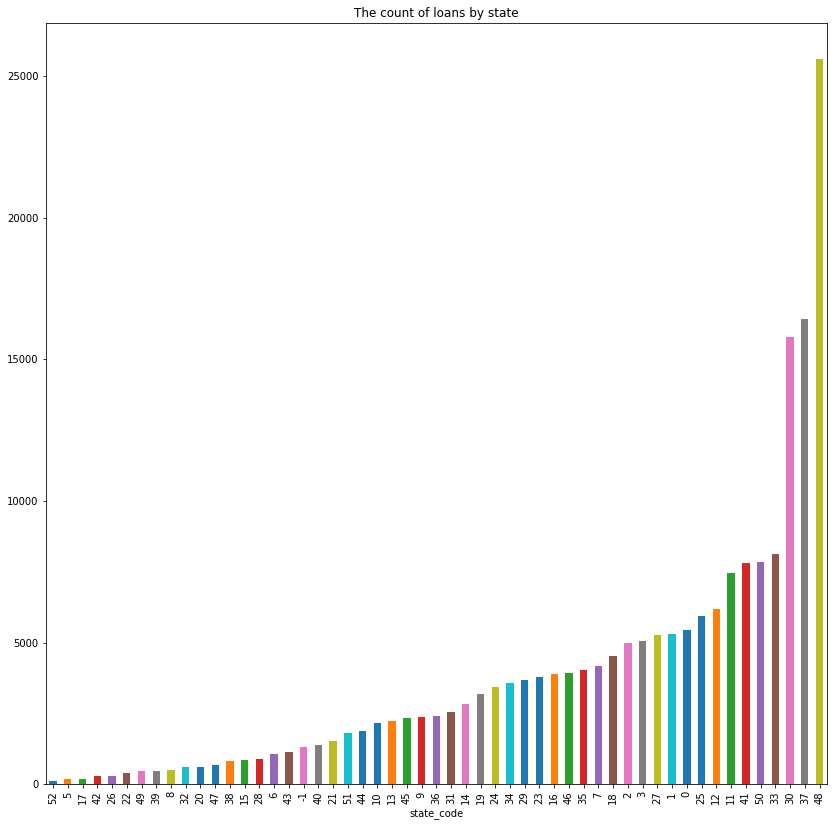

In [22]:
f = plt.figure(figsize=(14, 14))
plt.title('Count of loans')
training_data_pd.groupby('state_code')['rate_spread'].count().sort_values().plot(kind='bar')
plt.title('The count of loans by state')
plt.show()

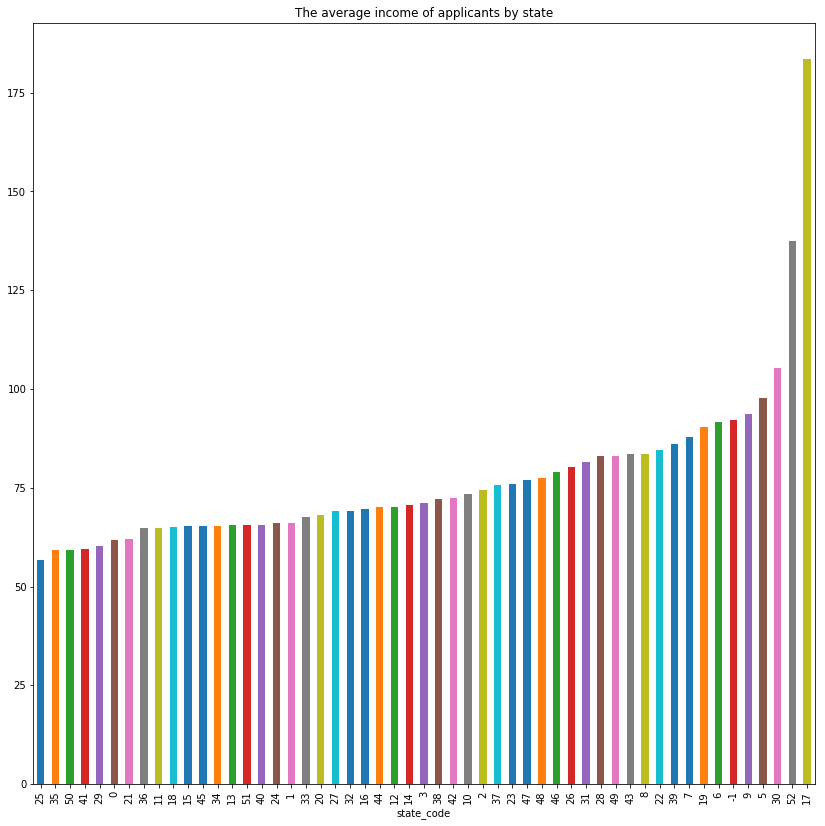

In [23]:
f = plt.figure(figsize=(14, 14))
plt.title('Average income')
training_data_pd.groupby('state_code')['applicant_income'].mean().sort_values().plot(kind='bar')
plt.title('The average income of applicants by state')
plt.show()

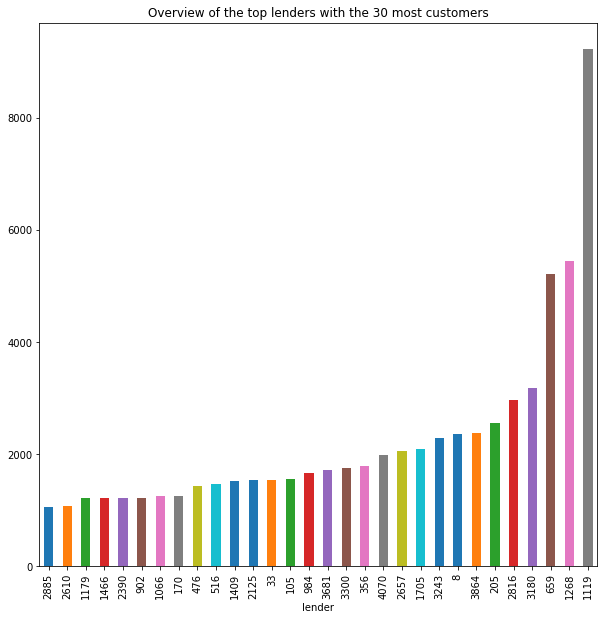

In [24]:
f = plt.figure(figsize=(10, 10))
training_data_pd.groupby('lender')['rate_spread'].count().sort_values().tail(30).plot(kind='bar')
plt.title('Overview of the top lenders with the 30 most customers')
plt.show()

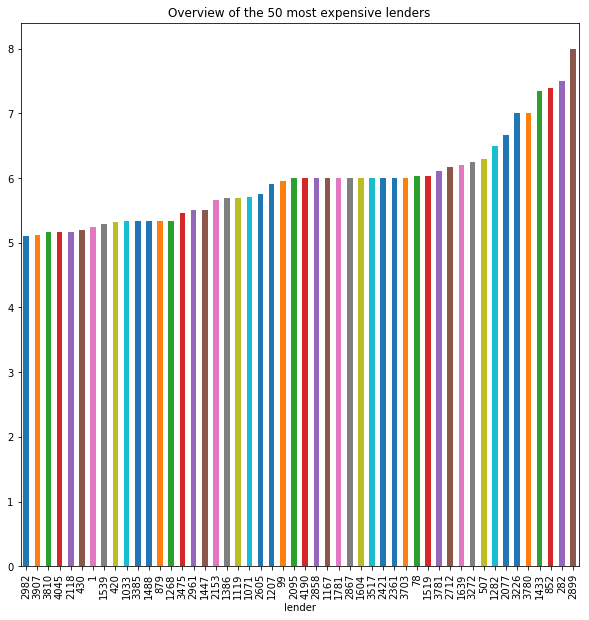

In [25]:
f = plt.figure(figsize=(10, 10))
training_data_pd.groupby('lender')['rate_spread'].mean().sort_values().tail(50).plot(kind='bar')
plt.title('Overview of the 50 most expensive lenders')
plt.show()

In [26]:
print("{} counties".format(training_data_pd.groupby('county_code')['loan_amount'].count().count()))

306 counties


In [32]:
training_data_pd.to_csv(TEMP_PATH+CLEANED_OUTPUT_FN)

In [35]:
training_data_pd.to_excel(TEMP_PATH+CLEANED_OUTPUT_FN_XLS, engine='xlsxwriter')